# Demo of the Pycle toolbox
This notebook provides a minimal working example of Compressive Learning with the `pycle` toolbox. It demonstrates the typical workflow with `pycle` and basic features. In particular, we will:
1. Generate a dataset
2. Sketch it by first generating our sketch operator
3. Use this sketch to estimate the centroids

In [1]:
# TODO check pip install stuff
# TODO fix the seed

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

## PART 0: generate a dataset with utils

To demonstrate the toolbox, we generate a simple synthetic dataset, from a Gaussian mixture model in two dimensions.

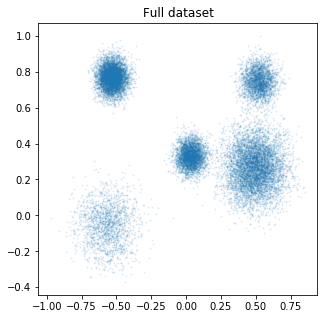

In [136]:
from pycle.utils import generatedataset_GMM

d = 2     # Dimension
K = 5     # Number of Gaussians
n = 20000 # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
(X,*_) = generatedataset_GMM(d,K,n,normalize='l_inf-unit-ball',balanced=False) 

# Visualize the dataset
plt.figure(figsize=(5,5))
plt.title("Full dataset")
plt.scatter(X[:,0],X[:,1],s=1, alpha=0.15)
plt.show()

## PART 1: sketching the dataset
We first compress the dataset as a sketch. All the tools required for this step are located in the `pycle.sketching` submodule (which we import under the handier alias `sk`). 

In [137]:
import pycle.sketching as sk

Recall that the sketch of a dataset $X$ is given by

$$ \boldsymbol z = \sum_{\boldsymbol x_i \in X} \Phi(\boldsymbol x_i) $$

We first generate the feature map $\Phi$. In this simple example, we chose here random Fourier features $\Phi(\boldsymbol x) = \exp(\mathrm{i}\Omega^T\boldsymbol x)$, which is the usual choice for k-means and GMM fitting. In this expression, $\Omega$ is a matrix of $m$ "frequency" vectors, generated from $\boldsymbol \omega_j \sim \Lambda$ (without entering into the details, in this case we pick a Folded Gaussian distribution parametrized by $\Sigma$, which should roughly represent the covariance of the desired clusters). The sketch size $m$ should here be of the order of the number of parameters to estimate, here the number of centroid coordinates, $Kd$.

In [138]:
# Pick the dimension m: 5*K*d is usually (just) enough in clustering (here m = 50)
m = 5*K*d 

# For this simple example, assume we have a priori a rough idea of the size of the clusters
Sigma = 0.05*np.eye(d)

# According to the Folded Gaussian rule, we want m frequencies in dimension d, parametrized by Sigma
Omega = sk.drawFrequencies("FoldedGaussian",d,m,Sigma)

# The feature map is a standard one, the complex exponential of projections on Omega^T
Phi = sk.SimpleFeatureMap("ComplexExponential",Omega)

# And sketch X with Phi: we map a 20000x2 dataset -> a 50-dimensional complex vector
z = sk.computeSketch(X,Phi)

## PART 2: compressive learning from the sketch
Now that we have computed `z`, we want to learn from this sketch alone. Algorithms that learn from the sketch are  available in the `pycle.compressive_learning` submodule (which we simply refer to as `cl`). 

In [139]:
import pycle.compressive_learning as cl

The naming convention for the algorithms in `cl` is the pattern `algorithmName_targetTask`. So, to solve compressive k-means (CKM) with the CLOMP-R algorithm, we call `cl.CLOMPR_CKM`.

In [148]:
# We provide (only) the sketch, the feature map, and the desired number of centroids
(weights,centroids) = cl.CLOMPR_CKM(z,Phi,K)

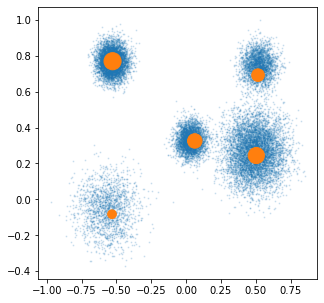

In [149]:
# Visualize the centroids (we re-use the dataset for visual comparison)
plt.figure(figsize=(5,5))

plt.scatter(X[:,0],X[:,1],s=1, alpha=0.15)
plt.scatter(centroids[:,0],centroids[:,1],s=1000*weights)
plt.show()

As you can see, thanks to `pycle` only a few lines of code suffice to start doing compressive learning. In the next demos, we show how to use some other features of the toolbox, such as automatically setting $\Sigma$, solving other tasks (GMM), and a privacy-preservation layer on top of the sketch, and using quantized sketch contributions.